#### SURE-ERGAS: UNSUPERVISED DEEP LEARNING MULTISPECTRAL AND HYPERSPECTRAL IMAGE FUSION
IEEE IGARSS 2023, Pasadena, California, USA, 17-22 July, 2023 <br/>
Han V. Nguyen$^∗$ , Magnus O. Ulfarsson ∗ , Johannes R. Sveinsson$^∗$ , and Mauro Dalla Mura$^†$
$^∗$<br/>
Faculty of Electrical and Computer Engineering, University of Iceland, Reykjavik, Iceland
$^†$<br/>
GIPSA-Lab, Grenoble Institute of Technology, Saint Martin d’Hères, France.

**Main ideas:** Training a CNN for MS-HS fusion using a loss function based on ERGAS (relative dimensionless global error synthesis) and SURE (Stein's unbiased risk estimate) where the MSE (mean square error) used in computation ERGAS is estimated by SURE. The SURE-ERGAS loss function allow unsupervised training and avoid balancing the spectral and spatial terms as in the loss function solely based on SURE. 

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import matplotlib.pyplot as plt
import numpy as np
import math
import torch
import torch.optim
import scipy.io as sio
from skimage.metrics import peak_signal_noise_ratio as psnr
from models.hs_models import *
from utils.hs_utils import *
from utils.common_utils import *
print(torch.cuda.get_device_name())

NVIDIA TITAN X (Pascal)


Generate simulated data, the Pavia University (PU)) dataset. Ground truth is $200\times200\times93$ hyperspectral data cube, $\mathbf{X}$. MSI, $\mathbf{G}$ is created by applying spectrally degradation $\mathbf{R}$ to $\mathbf{X}$, i.e., $$\mathbf{G}=\mathbf{XR}$$
HSI, $\mathbf{y}$ is created by applying spatially degradation $\mathbf{H}$ to $\mathbf{x}$, i.e., $$\mathbf{y}=\mathbf{Hx}$$

In [2]:
path_to_data = 'data/HS/pu_hsms.mat'
X = sio.loadmat(path_to_data)['Zim'] # Ground truth (HR HSI)
srf = sio.loadmat(path_to_data)['R'] #spectral response
R=np.transpose(srf)
factor=4 #downsampling factor
[r,c,n_channels]=X.shape
X_torch=torch.from_numpy(X).to(device,dtype=torch.float)
R_torch=torch.from_numpy(R).to(device,dtype=torch.float)
##########Simulate MSI bands by spectrally degradation and adding noise
MSI=hwc2chw(hsi2msi(X_torch,R_torch)) # G=XR
scale_m=torch.max(MSI)
MSI=MSI/scale_m
SNRm=40.
[msi,sigmam]=add_noise(MSI,SNRm)
##########Simulate LR-HSI by filtering, downsampling (factor = 4) and adding noise
####Get PSF for the HSI, gaussian = False -->Starg-Mutargh filter
psf=get_hs_psf(N=15, n_channels = n_channels, gaussian=True,sigma=2.)
x=hwc2chw(X_torch).to(device,dtype=torch.float)
hsi_LR = Ax(x,psf,ratio=factor) # y=Hx
# # Case 2 (high noise): Uniform sigma (0-0.1)
# sigmah = torch.rand(n_channels,1)
# torch.save(sigmah,'sigmah.pt')
sigmah=torch.load('sigmah.pt')
hsi=add_bandwise_noise(hsi_LR,sigmah)
# # Case 1 (low noise): isotropic Gaussian noise
# SNRh=25.
# [hsi,sigmah]=add_noise(hsi_LR,SNRh)
cond=1e-3
hsiup = back_projx(hsi,psf,factor,cond)
ref = X #np
sigmah=sigmah.reshape(n_channels,1,1).to(device) #need this for Case 2

MS bands shape:  torch.Size([4, 200, 200])
HS bands shape:  torch.Size([93, 50, 50])
torch.Size([93, 1, 1])
11.200082949212744
40.015490718913966


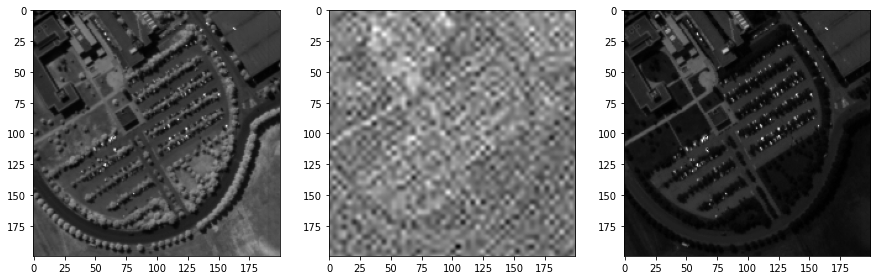

In [3]:
## Image information
print('MS bands shape: ', msi.shape)
print('HS bands shape: ', hsi.shape)
print(sigmah.shape)
print(SNRCal(hsi_LR.cpu().numpy(),hsi.cpu().numpy()))
print(SNRCal(MSI.cpu().numpy(),msi.cpu().numpy()))

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(15,15))
ax1.imshow(msi[3,:,:].cpu(),cmap='gray')
ax2.imshow(hsiup[11,:,:].cpu(),cmap='gray')
ax3.imshow(ref[:,:,11],cmap='gray')
plt.show()

In [4]:
def ergas(I,I_fus,r):
    '''ERGAS (numpy)
    input: I: reference
           I_Fus: estimated image
           r: ratio between LR and HR'''
    mse = np.mean((I-I_fus)**2, axis=(0,1))
    mu_sq = np.mean(I,axis=(0,1))**2
    return (100/r)*np.sqrt(np.mean(mse/mu_sq))
def rmse(I,I_fus):
    return np.sqrt(np.mean((I-I_fus)**2))

In [5]:
def mse_loss(model,inputs,targets,psf_hs, R, sigmah,sigmam,cond):
    '''Loss function computes MSE between fused image and ground truth, which is estimated by SURE
    Input: model --> a CNN
           inputs, targests: input of the CNN and target (label)
           psf_hs: PSF (defined in utils.hs_utils
           sigmah: std.dev. of HSI bands
           sigmam: std.dev. of MSI bands
           R: spectral response function
           cond: condition number to regularize the inverse matrix
    Output: MSE (a number)'''
    ym = targets[0] #ms
    yh=targets[1] #hs = target
    sigmah_sq=sigmah**2
    sigmam_sq=sigmam**2
    ratio=4
    xhat=model(inputs)
    yhat=Ax(xhat.squeeze(),psf_hs,ratio) - yh
    pyhat = back_projx(yhat,psf_hs,ratio,cond)
    out_msi_torch = hwc2chw(hsi2msi(chw2hwc(xhat.squeeze()),R))/scale_m #Nxnm
    #### Compute the trace (divergence) term by using Monte-Carlo SURE  
    epsilon = 1e-5
    b = torch.randn(inputs.shape).to(device,dtype=torch.float)
    outb = (model(inputs+epsilon*b)-xhat)/epsilon
    outb_m = hwc2chw(hsi2msi(chw2hwc(outb.squeeze()),R))/scale_m*sigmam_sq #Nxnm
    Houtb_h = Ax(outb.squeeze(), psf_hs, ratio)
    tmp=invAAtx(Houtb_h,psf_hs,ratio,cond)*sigmah_sq
    outep = back_projx(tmp,psf_hs,ratio,cond)
    lam = 0.001 #tuning parameter balancing the spectral and spatial term (lambda = 0.01 Case 1, lambda=0.001 case 2)

    divh = 2 * torch.sum(b.squeeze()[4:,:,:] * outep) 
    divm= 2*torch.sum(b.squeeze()[:4,:,:]*outb_m) 
    bp_loss = torch.sum((ym-out_msi_torch)**2) + lam*torch.sum(pyhat**2) 
    sure_loss = bp_loss + divm + lam*divh
    return  sure_loss, xhat

In [6]:
def ergas_loss(model,inputs,targets,psf_hs, R, sigmah,sigmam,cond):
    '''Loss function computes ERGAS where MSE of a band is estimated using SURE
    Input: model --> a CNN
           inputs, targests: input of the CNN and target (label)
           psf_hs: PSF (defined in utils.hs_utils
           sigmah: std.dev. of HSI bands
           sigmam: std.dev. of MSI bands
            R: spectral response function
           cond: condition number to regularize the inverse matrix
    Output: ERGAS (a number)'''
    ym = targets[0] #ms
    yh = targets[1] #hs = target
    mu_m = torch.mean(ym,dim=(1,2))**2
    mu_h = torch.mean(yh,dim=(1,2))**2
    sigmah_sq = sigmah**2
    sigmam_sq = sigmam**2
    ratio = 4
    xhat = model(inputs)
    yhat = Ax(xhat.squeeze(),psf_hs,ratio) - yh
    pyhat = back_projx(yhat,psf_hs,ratio,cond)
    out_msi_torch = hwc2chw(hsi2msi(chw2hwc(xhat.squeeze()),R))/scale_m #Nxnm
    #### Compute the trace (divergence) term by using Monte-Carlo SURE  
    epsilon = 1e-5
    b = torch.randn(inputs.shape).to(device,dtype=torch.float)
    outb = (model(inputs+epsilon*b)-xhat)/epsilon
    outb_m = hwc2chw(hsi2msi(chw2hwc(outb.squeeze()),R))/scale_m*sigmam_sq #Nxnm
    Houtb_h = Ax(outb.squeeze(), psf_hs, ratio)
    tmp=invAAtx(Houtb_h,psf_hs,ratio,cond)*sigmah_sq
    outep = back_projx(tmp,psf_hs,ratio,cond)

    div_h = 2 * torch.sum(b.squeeze()[4:,:,:] * outep,dim=(1,2)) # 1xnh vector
    div_m= 2*torch.sum(b.squeeze()[:4,:,:]*outb_m,dim=(1,2))  # 1xnm vector 
    fid_h = torch.sum(pyhat**2,dim=(1,2)) 
    fid_m = torch.sum((ym-out_msi_torch)**2,dim=(1,2))
    mse_h = fid_h + div_h
    mse_m = fid_m + div_m
    
    ergas_h = (100/ratio)*torch.sqrt(torch.mean(mse_h/mu_h))
    ergas_m = (100/1)*torch.sqrt(torch.mean(mse_m/mu_m))
    return ergas_m + 1*ergas_h, xhat #adjust the number with ergas_h for experiments

In [7]:
show_every = 500
num_iter = 3001
LR = 0.01
net_inputs = torch.cat((msi,hsiup),dim=0)[None,:] # Inputs = [MSI,back_proj(HSI)]
targets=[msi,hsi] #targets = inputs
# Unet with skip connection
net = hs_net(ym_channel=4, yh_channel=n_channels, num_channels_down=64, 
           num_channels_up=64, num_channels_skip=4).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=LR,  amsgrad=True)

Starting optimization with ADAM


<ipython-input-8-dafac161f1ad>:24: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  current_psnr = psnr(ref,out_np)


Iteration 00000  ERGAS = 59.87321 PSNR = 9.241


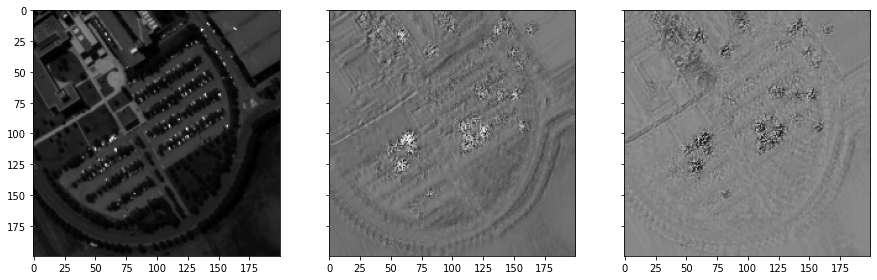

Iteration 00500  ERGAS = 2.08939 PSNR = 37.027


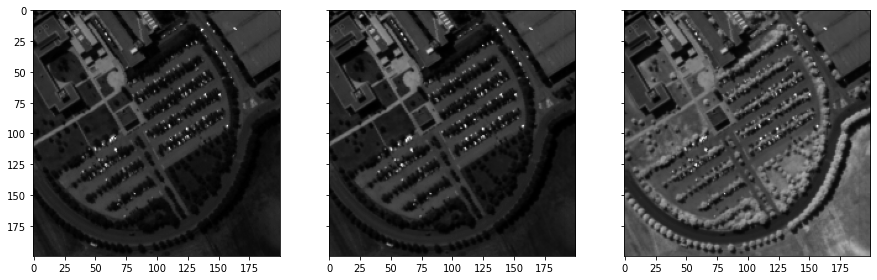

Iteration 01000  ERGAS = 1.94664 PSNR = 37.790


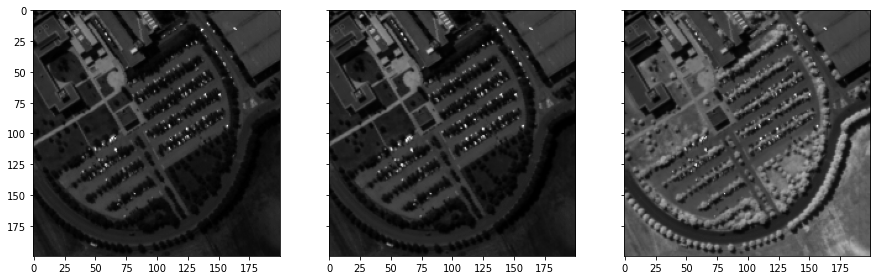

Iteration 01500  ERGAS = 1.94760 PSNR = 37.994


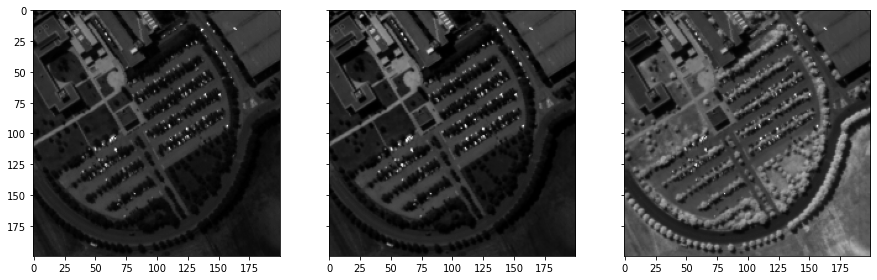

Iteration 02000  ERGAS = 1.76878 PSNR = 38.532


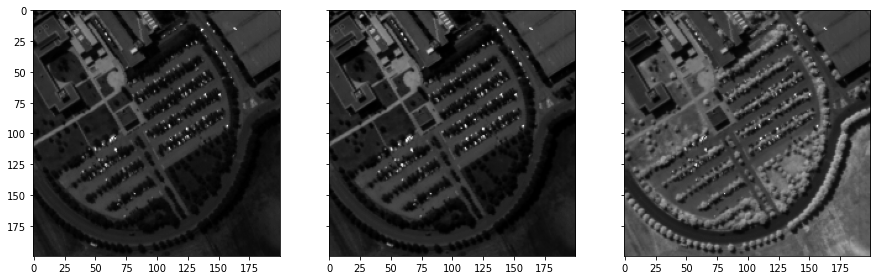

Iteration 02500  ERGAS = 1.74694 PSNR = 38.689


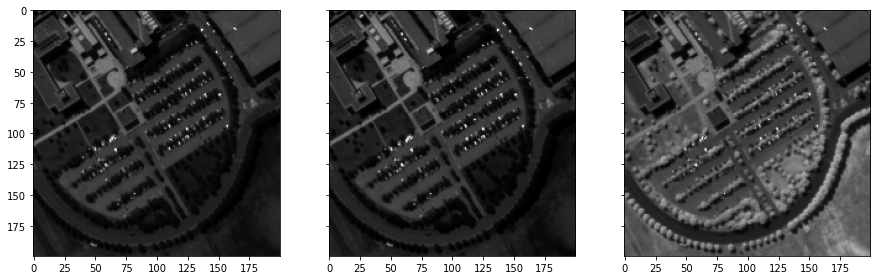

Iteration 03000  ERGAS = 1.79663 PSNR = 38.500


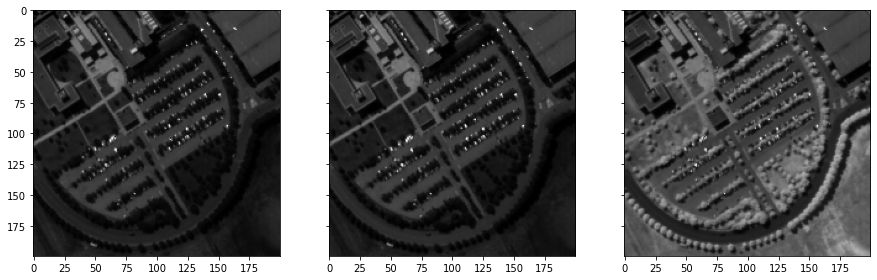

In [8]:
total_loss=[]
sre_history=[]
ergas_total = []
# true_R=[]
print('Starting optimization with ADAM')
out_avg=None
exp_weight=0.99

for it in range(num_iter):
    optimizer.zero_grad()
    loss, out_HR = ergas_loss(net,net_inputs,targets,psf,R_torch,sigmah,sigmam,cond) # SURE-ERGAS
          
#     loss, out_HR = mse_loss(net,net_inputs,targets,psf,R_torch,sigmah,sigmam,cond,loss_type=loss_type) # SURE-MSE
    # Track the PSNR of reconstructed image
    out_np = chw2hwc(out_HR.detach().cpu().squeeze()).numpy()
    # (Optional): Smoothing output by running average over training iterations
#     if out_avg is None:
#         out_avg = out_np
#     else:
#         out_avg = out_avg * exp_weight + out_np * (1 - exp_weight)
#     if it==3000:
#         sio.savemat("pu_out"+loss_type+"_hn"+".mat",mdict={"img_"+loss_type:out_avg,"ref":ref,"sigmah":sigmah.cpu().numpy()})
    
    current_psnr = psnr(ref,out_np)
    ERGAS =ergas(ref,out_np,4)
    sre_history.append(current_psnr)
    total_loss.append(loss.detach().cpu().numpy())
    ergas_total.append(ERGAS)
    
    loss.backward()
    optimizer.step()
    if it % show_every == 0:
        print('Iteration %05d  ERGAS = %.5f PSNR = %.3f' % (it,ERGAS,current_psnr))
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,15))
        ax1.imshow(ref[:,:,41],cmap='gray')
        ax2.imshow(out_np[:,:,41],cmap='gray')
        ax3.imshow(out_np[:,:,80],cmap='gray')
        plt.show()

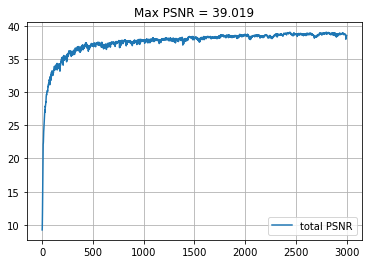

In [9]:
# Show results
psnr_history=np.array(sre_history)
loss_history=np.array(total_loss)
ergas_history= np.array(ergas_total)
a=np.max(psnr_history)

plt.plot(psnr_history,label='total PSNR')

plt.grid()
plt.title('Max PSNR = '+str(np.round(a,3)))
plt.legend()
plt.show()